In [9]:
pip install pandas lxml


Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install html5lib

     |████████████████████████████████| 112 kB 854 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install --upgrade beautifulsoup4

     |████████████████████████████████| 187 kB 936 kB/s eta 0:00:01
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.11.1
    Uninstalling beautifulsoup4-4.11.1:
      Successfully uninstalled beautifulsoup4-4.11.1
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install selenium


     |████████████████████████████████| 9.4 MB 7.5 MB/s eta 0:00:01
     |████████████████████████████████| 499 kB 8.6 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 7.7 MB/s eta 0:00:011
     |████████████████████████████████| 58 kB 13.9 MB/s eta 0:00:01
  Attempting uninstall: sniffio
    Found existing installation: sniffio 1.2.0
    Uninstalling sniffio-1.2.0:
      Successfully uninstalled sniffio-1.2.0
  Attempting uninstall: websocket-client
    Found existing installation: websocket-client 0.58.0
    Uninstalling websocket-client-0.58.0:
      Successfully uninstalled websocket-client-0.58.0
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install webdriver-manager

Note: you may need to restart the kernel to use updated packages.


"""

📊 DC Breeze Team Stats Scraper (2022–2024)
------------------------------------------
This script uses Selenium and pandas to extract match statistics 
for the DC Breeze Ultimate Frisbee team from the WatchUFA website 
for the 2022, 2023, and 2024 seasons.

It automates Safari to access:
https://watchufa.com/stats/team-game-stats?team=breeze

The extracted tables are:
- Cleaned and combined into one DataFrame
- Saved to a single CSV file: `dc_breeze_stats_last_3_season.csv`
"""


"""
Wind Speed Data Collector for Ultimate Frisbee Matches
 This script reads match dates and locations from `manual_match_list.csv`
and queries the Visual Crossing Weather API to fetch wind speed data
for each game. It handles API rate limits and saves the result to 
`Windspeed_data_for_each_date.csv`.
"""

In [ ]:
from selenium import webdriver
import time
import pandas as pd

# Safari driver'ı başlat
driver = webdriver.Safari()

# Yıllar
years = [2024, 2023, 2022]
all_data = []

for year in years:
    print(f"📅 Veriler alınıyor: {year}")
    url = f"https://watchufa.com/stats/team-game-stats?team=breeze&year={year}"
    driver.get(url)
    time.sleep(5)  # sayfanın yüklenmesini bekle

    try:
        html = driver.page_source
        tables = pd.read_html(html)
        df = tables[0]
        df['Season'] = year  # yıl bilgisini ekle
        all_data.append(df)
    except Exception as e:
        print(f"❌ {year} yılı verisi alınamadı: {e}")

# Tüm yılların verilerini birleştir
final_df = pd.concat(all_data, ignore_index=True)

# CSV olarak kaydet
final_df.to_csv("dc_breeze_stats_2022_2024.csv", index=False)

# Tarayıcıyı kapat
driver.quit()

print("✅ Tüm sezon verileri başarıyla kaydedildi: dc_breeze_stats_2022_2024.csv")

In [1]:
import pandas as pd
import requests
import csv
import time
from datetime import datetime
from typing import Union
from scipy.stats import ttest_ind, pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ─── CONFIG ─────────────────────────────────────────────
API_KEY     = "TUFUHU6ERDAHNALFJY7YU56Y6"
INPUT_CSV   = "manual_match_list.csv"
OUTPUT_CSV  = "manual_match_wind_data.csv"
SECONDS_BETWEEN_CALLS = 6
WAIT_IF_429_SECONDS   = 65
# ───────────────────────────────────────────────────────

def fetch_wind(date_str: str, location: str) -> Union[float, None]:
    url = (
        "https://weather.visualcrossing.com/VisualCrossingWebServices/rest/"
        f"services/timeline/{location}/{date_str}"
        f"?unitGroup=metric&key={API_KEY}&contentType=json"
    )
    while True:
        r = requests.get(url)
        status = r.status_code
        if status == 200 and r.text.strip():
            try:
                return r.json()["days"][0]["windspeed"]
            except Exception:
                return None
        elif status == 429:
            print("   ⏳ 429 Too Many Requests → waiting a minute …")
            time.sleep(WAIT_IF_429_SECONDS)
            continue
        else:
            print(f"   ⚠️  {status} error for {date_str} @ {location}")
            return None

def main():
    # 🧾 Read tab-delimited CSV
    df = pd.read_csv(INPUT_CSV, delimiter="\t")
    df.columns = df.columns.str.strip()
    print("✅ Columns:", df.columns.tolist())

    # 🎯 Salt Lake City düzeltmesi
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df["Location"] = df.apply(
        lambda row: "Salt Lake City,UT" if row["Date"] == pd.to_datetime("2024-08-23") else row["Location"],
        axis=1
    )

    wind_rows = []

    for _, row in df.iterrows():
        date_obj = row["Date"]
        location = row["Location"]
        if pd.isna(date_obj) or pd.isna(location):
            continue
        date_str = date_obj.strftime("%Y-%m-%d")

        print(f"📅 {date_str.ljust(12)} | 🏟  {location}")
        wind_speed = fetch_wind(date_str, location)
        wind_rows.append({
            "Date": date_str,
            "Location": location,
            "Wind Speed (m/s)": wind_speed
        })
        time.sleep(SECONDS_BETWEEN_CALLS)

    # 💾 Write CSV
    with open(OUTPUT_CSV, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=["Date", "Location", "Wind Speed (m/s)"])
        writer.writeheader()
        writer.writerows(wind_rows)

    print(f"\n✅ Finished. Wind data saved to {OUTPUT_CSV}")

if __name__ == "__main__":
    main()

/Users/tolgaerguner/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/tolgaerguner/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


✅ Columns: ['Date', 'Location', 'Unnamed: 2']
📅 2024-08-23   | 🏟  Salt Lake City,UT
📅 2024-08-10   | 🏟  Washington
📅 2024-07-20   | 🏟  New York
📅 2024-06-28   | 🏟  Washington
📅 2024-06-22   | 🏟  Washington
📅 2024-06-16   | 🏟  Montreal
📅 2024-06-15   | 🏟  Toronto
📅 2024-06-08   | 🏟  Washington
📅 2024-06-02   | 🏟  Boston
📅 2024-05-31   | 🏟  Washington
📅 2024-05-18   | 🏟  Philadelphia
📅 2024-05-10   | 🏟  Washington
📅 2024-05-05   | 🏟  Philadelphia
📅 2024-04-27   | 🏟  Salt Lake City
📅 2023-08-12   | 🏟  New York
📅 2023-07-29   | 🏟  Washington
📅 2023-07-21   | 🏟  Washington
📅 2023-07-15   | 🏟  Philadelphia
📅 2023-07-08   | 🏟  Washington
📅 2023-06-30   | 🏟  New York
📅 2023-06-24   | 🏟  Boston
📅 2023-06-23   | 🏟  Montreal
📅 2023-06-16   | 🏟  Washington
📅 2023-06-02   | 🏟  Raleigh
📅 2023-05-20   | 🏟  Washington
📅 2023-05-13   | 🏟  Washington
📅 2023-05-07   | 🏟  Washington
📅 2023-04-29   | 🏟  Raleigh
📅 2022-08-20   | 🏟  New York
📅 2022-08-13   | 🏟  Washington
📅 2022-07-29   | 🏟  Washington
📅 202

# Wind vs. Turnover Rate Analysis - Ultimate Frisbee (DC Breeze)


In [42]:
# 1. Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, pearsonr

In [43]:
#  2. Load datasets
df_stats = pd.read_csv("dc_breeze_stats_last_3_season.csv")
df_wind = pd.read_csv("Windspeed_data_for_each_date.csv")

In [44]:
# 3. Clean and merge -> some of the column started with space etc. to prevent this, cleaning before merge.
df_stats.columns = df_stats.columns.str.strip()
df_stats["Date"] = pd.to_datetime(df_stats["Date"])
df_wind["Date"] = pd.to_datetime(df_wind["Date"])
df = pd.merge(df_stats, df_wind, on="Date", how="inner")

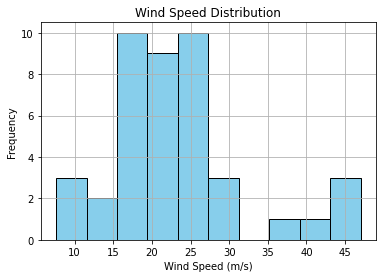

In [45]:
## Histogram of Wind Speed


plt.figure(figsize=(6, 4))
plt.hist(df["Wind Speed (m/s)"].dropna(), bins=10, color='skyblue', edgecolor='black')
plt.title("Wind Speed Distribution")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

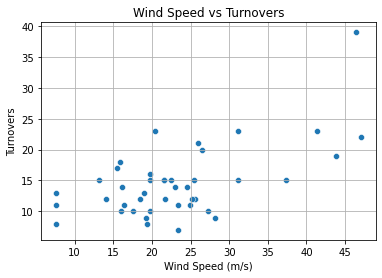

In [10]:
## Scatter Plot: Wind vs Turnovers
plt.figure(figsize=(6,4))
sns.scatterplot(x="Wind Speed (m/s)", y="Turnovers", data=df)
plt.title("Wind Speed vs Turnovers")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Turnovers")
plt.grid(True)
plt.show()

/Users/tolgaerguner/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


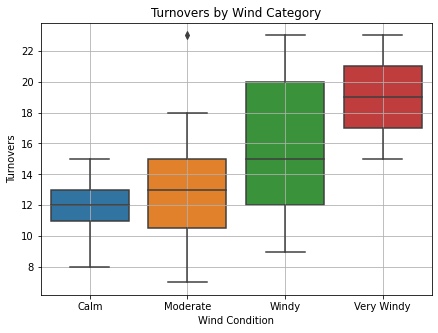

In [11]:
## Boxplot: Group wind into categories
bins = [0, 15, 25, 35, 45]
labels = ["Calm", "Moderate", "Windy", "Very Windy"]
df["Wind Category"] = pd.cut(df["Wind Speed (m/s)"], bins=bins, labels=labels)
plt.figure(figsize=(7,5))
sns.boxplot(x="Wind Category", y="Turnovers", data=df)
plt.title("Turnovers by Wind Category")
plt.xlabel("Wind Condition")
plt.ylabel("Turnovers")
plt.grid(True)
plt.show()

# Hypothesis Testing

In [17]:
corr, p_corr = pearsonr(df["Wind Speed (m/s)"], df["Turnovers"])
print(f"Pearson correlation: {corr:.2f}, p-value: {p_corr:.2e}")

Pearson correlation: 0.60, p-value: 2.23e-05


###### The Pearson correlation between wind speed and turnover count is 0.60, with a p-value of 0.0000223. This indicates a strong positive correlation that is statistically significant at the 5% level.

In [19]:
## T-test: Calm vs Windy+Very Windy
group_calm = df[df["Wind Category"] == "Calm"]["Turnovers"]
group_windy = df[df["Wind Category"].isin(["Windy", "Very Windy"])]

t_stat, p_value = ttest_ind(group_calm, group_windy["Turnovers"], equal_var=False, nan_policy='omit')
print(f"T-test result: t={t_stat:.2f}, p={p_value:.4f}")

T-test result: t=-2.38, p=0.0324


To test whether windier conditions lead to significantly more turnovers, a two-sample t-test was performed comparing games played in **calm** vs. **windy/very windy** conditions.

- **t-statistic:** -2.38
- **p-value:** 0.0324

The result indicates that the difference in average turnovers is **not statistically significant** at the 5% level. Therefore, while the correlation analysis suggested a moderate positive relationship, this specific test does not provide strong evidence that high wind directly causes more turnovers across groups.

It’s possible that sample size, variance, or grouping thresholds affected this result.

In [47]:
import re
import numpy as np

# ✅ Define the function first
def extract_pct(x):
    if isinstance(x, str):
        m = re.search(r"(\d+)%", x)
        if m:
            return float(m.group(1)) / 100.0
    return np.nan

# ✅ Then use it
percent_cols = ["Completion %", "Huck %", "Hold %", "OLC %", "Break %", "DLC %", "RZC %"]
for col in percent_cols:
    df[col] = df[col].apply(extract_pct)

In [48]:
# Fill missing percent values with column medians
df[percent_cols] = df[percent_cols].fillna(df[percent_cols].median())

In [49]:
# Ensure Wind Speed is numeric
df["Wind Speed (m/s)"] = pd.to_numeric(df["Wind Speed (m/s)"], errors="coerce")

In [50]:
# Final features and target
features = ["Wind Speed (m/s)"] + percent_cols
df = df.dropna(subset=features + ["Turnovers"])
X = df[features]
y = df["Turnovers"].astype(int)

In [52]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train models
lr = LinearRegression().fit(X_train, y_train)
dt = DecisionTreeRegressor(random_state=42).fit(X_train, y_train)


In [53]:
# Predictions
y_pred_lr = lr.predict(X_test)
y_pred_dt = dt.predict(X_test)

In [54]:
# Evaluation
print("🔍 Linear Regression → R²: {:.2f}, MSE: {:.2f}".format(r2_score(y_test, y_pred_lr), mean_squared_error(y_test, y_pred_lr)))
print("🌲 Decision Tree     → R²: {:.2f}, MSE: {:.2f}".format(r2_score(y_test, y_pred_dt), mean_squared_error(y_test, y_pred_dt)))


🔍 Linear Regression → R²: -0.97, MSE: 30.77
🌲 Decision Tree     → R²: 0.69, MSE: 4.89


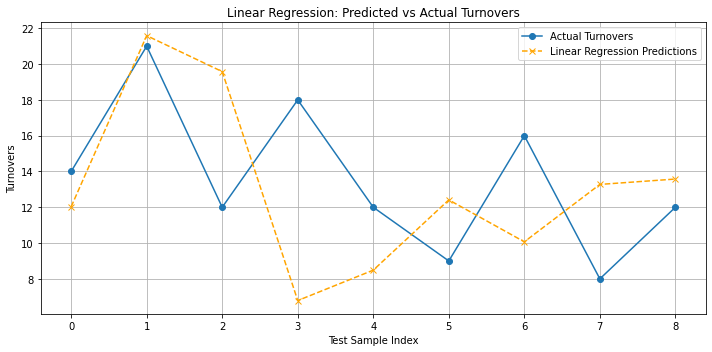

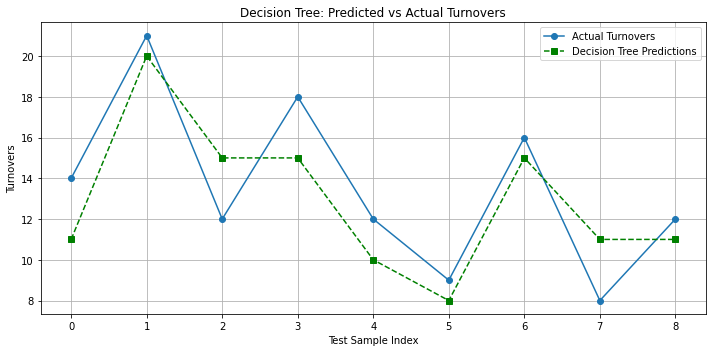

In [56]:
# 📉 Linear Regression vs Actuals
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="Actual Turnovers", marker='o')
plt.plot(y_pred_lr, label="Linear Regression Predictions", linestyle='--', marker='x', color='orange')
plt.title("Linear Regression: Predicted vs Actual Turnovers")
plt.xlabel("Test Sample Index")
plt.ylabel("Turnovers")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 🌲 Decision Tree vs Actuals
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="Actual Turnovers", marker='o')
plt.plot(y_pred_dt, label="Decision Tree Predictions", linestyle='--', marker='s', color='green')
plt.title("Decision Tree: Predicted vs Actual Turnovers")
plt.xlabel("Test Sample Index")
plt.ylabel("Turnovers")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [57]:
from sklearn.ensemble import RandomForestRegressor

# 🔁 Train the model
rf = RandomForestRegressor(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)

# 🔮 Predict
y_pred_rf = rf.predict(X_test)

# 📊 Evaluate
from sklearn.metrics import mean_squared_error, r2_score

print("🌳 Random Forest     → R²: {:.2f}, MSE: {:.2f}"
      .format(r2_score(y_test, y_pred_rf),
              mean_squared_error(y_test, y_pred_rf)))

🌳 Random Forest     → R²: 0.71, MSE: 4.57


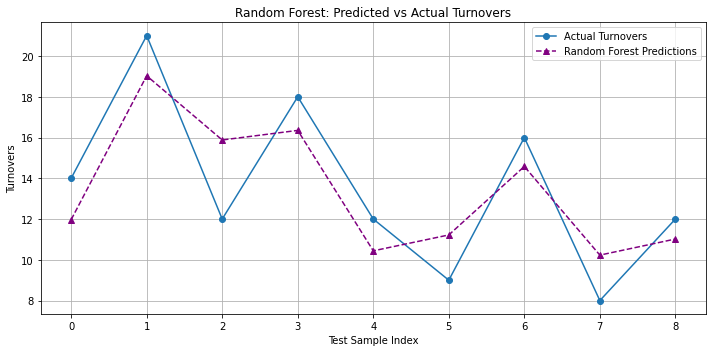

In [58]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="Actual Turnovers", marker='o')
plt.plot(y_pred_rf, label="Random Forest Predictions", linestyle='--', marker='^', color='purple')
plt.title("Random Forest: Predicted vs Actual Turnovers")
plt.xlabel("Test Sample Index")
plt.ylabel("Turnovers")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()